In [ ]:
!pip install nltk

In [ ]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
from nltk.corpus import wordnet as wn

# List all synset names
synsets = list(wn.all_synsets())

# Extract relations between synsets
relations = []

for synset in synsets:
    # Hypernyms and instance_hypernyms
    relations.extend([(str(synset), 'hypernym', str(hypernym)) for hypernym in synset.hypernyms()])
    relations.extend([(str(synset), 'instance_hypernym', str(i_hypernym)) for i_hypernym in synset.instance_hypernyms()])

    # Hyponyms and instance_hyponyms
    relations.extend([(str(synset), 'hyponym', str(hyponym)) for hyponym in synset.hyponyms()])
    relations.extend([(str(synset), 'instance_hyponym', str(i_hyponym)) for i_hyponym in synset.instance_hyponyms()])

    # Meronyms: member, part, substance
    relations.extend([(str(synset), 'member_meronym', str(meronym)) for meronym in synset.member_meronyms()])
    relations.extend([(str(synset), 'part_meronym', str(meronym)) for meronym in synset.part_meronyms()])
    relations.extend([(str(synset), 'substance_meronym', str(meronym)) for meronym in synset.substance_meronyms()])

    # Holonyms: member, part, substance
    relations.extend([(str(synset), 'member_holonym', str(holonym)) for holonym in synset.member_holonyms()])
    relations.extend([(str(synset), 'part_holonym', str(holonym)) for holonym in synset.part_holonyms()])
    relations.extend([(str(synset), 'substance_holonym', str(holonym)) for holonym in synset.substance_holonyms()])

    # Other relations
    relations.extend([(str(synset), 'attribute', str(attribute)) for attribute in synset.attributes()])
    relations.extend([(str(synset), 'entailments', str(entailment)) for entailment in synset.entailments()])
    relations.extend([(str(synset), 'causes', str(cause)) for cause in synset.causes()])
    relations.extend([(str(synset), 'also_sees', str(related)) for related in synset.also_sees()])
    relations.extend([(str(synset), 'verb_group', str(group)) for group in synset.verb_groups()])
    relations.extend([(str(synset), 'similar_tos', str(similar)) for similar in synset.similar_tos()])

    for lemma in synset.lemmas():
        relations.extend([(str(synset), 'antonym', str(antonym.synset())) for antonym in lemma.antonyms()])
        relations.extend([(str(synset), 'pertainym', str(pertainym.synset())) for pertainym in lemma.pertainyms()])
        relations.extend([(str(synset), 'derivationally_related', str(related.synset())) for related in lemma.derivationally_related_forms()])

# Now, `relations` is a list of triples (head, relation, tail)


In [ ]:
import torch
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt



class TransE:
    def __init__(self, num_entities, num_relations, embedding_dim=100, learning_rate=0.01, margin=1.0, norm='l2'):
        self.num_entities = num_entities
        self.num_relations = num_relations
        self.embedding_dim = embedding_dim
        self.learning_rate = learning_rate
        self.margin = margin
        self.norm = norm

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Initialize entity and relation embeddings
        self.entity_embeddings = torch.empty(num_entities, embedding_dim, device=self.device)
        torch.nn.init.uniform_(self.entity_embeddings, -6/np.sqrt(embedding_dim), 6/np.sqrt(embedding_dim))

        self.relation_embeddings = torch.empty(num_relations, embedding_dim, device=self.device)
        torch.nn.init.uniform_(self.relation_embeddings, -6/np.sqrt(embedding_dim), 6/np.sqrt(embedding_dim))

        # Normalize relation embeddings
        self.relation_embeddings = self.relation_embeddings / torch.norm(self.relation_embeddings, p=2, dim=1, keepdim=True)


    def _corrupt_triple(self, triple, triple_set):
        # Randomly replace either head or tail
        if torch.rand(1) < 0.5:  # Replace head
            while True:
                corrupted_head = torch.randint(self.num_entities, (1,)).item()
                corrupted_triple = (corrupted_head, triple[1], triple[2])
                # If corrupted triple is not in the original set, break the loop
                if corrupted_triple not in triple_set:
                    break
            return corrupted_triple
        else:  # Replace tail
            while True:
                corrupted_tail = torch.randint(self.num_entities, (1,)).item()
                corrupted_triple = (triple[0], triple[1], corrupted_tail)
                # If corrupted triple is not in the original set, break the loop
                if corrupted_triple not in triple_set:
                    break
            return corrupted_triple

    def train(self, triples, num_epochs, validation_triples=None, batch_size=128):
      epoch_losses = []

      triples = torch.tensor(triples, device=self.device)
      triple_set = set(tuple(t) for t in triples.tolist())

      num_batches = len(triples) // batch_size
      if len(triples) % batch_size != 0:
          num_batches += 1

      for epoch in range(num_epochs):


          indices = torch.randperm(len(triples), device=self.device)
          triples = triples[indices]

          for batch_num in range(num_batches):
              batch_start = batch_num * batch_size
              batch_end = (batch_num + 1) * batch_size
              batch_triples = triples[batch_start:batch_end]

              grad_head = torch.zeros(self.entity_embeddings.shape, device=self.device)
              grad_tail = torch.zeros(self.entity_embeddings.shape, device=self.device)
              grad_relation = torch.zeros(self.relation_embeddings.shape, device=self.device)

              loss = 0.0
              for triple in batch_triples:
                  corrupted_triple = self._corrupt_triple(triple.tolist(), triple_set)

                  score = self.score(triple)
                  corrupted_score = self.score(corrupted_triple)

                  current_loss = torch.clamp(self.margin + score - corrupted_score, min=0)
                  loss += current_loss

                  if current_loss != 0:
                      head, relation, tail = triple
                      if self.norm == 'l1':
                          positive_diff = (self.entity_embeddings[head] + self.relation_embeddings[relation] - self.entity_embeddings[tail]).sign()
                          negative_diff = (self.entity_embeddings[corrupted_triple[0]] + self.relation_embeddings[relation] - self.entity_embeddings[corrupted_triple[2]]).sign()

                          grad_head[head] += positive_diff
                          grad_tail[tail] -= positive_diff
                          grad_relation[relation] += positive_diff - negative_diff
                          grad_head[corrupted_triple[0]] -= negative_diff
                          grad_head[corrupted_triple[2]] += negative_diff
                      else:
                          positive_diff = 2 * (self.entity_embeddings[head] + self.relation_embeddings[relation] - self.entity_embeddings[tail])
                          negative_diff = 2 * (self.entity_embeddings[corrupted_triple[0]] + self.relation_embeddings[relation] - self.entity_embeddings[corrupted_triple[2]])

                          grad_head[head] += positive_diff
                          grad_tail[tail] -= positive_diff
                          grad_relation[relation] += positive_diff - negative_diff
                          grad_head[corrupted_triple[0]] -= negative_diff
                          grad_head[corrupted_triple[2]] += negative_diff



              self.entity_embeddings -= self.learning_rate * grad_head
              self.entity_embeddings -= self.learning_rate * grad_tail
              self.relation_embeddings -= self.learning_rate * grad_relation

              self.entity_embeddings = self.entity_embeddings / torch.norm(self.entity_embeddings, p=2, dim=1, keepdim=True)

              if (batch_num % 500 == 0):
                  print(f'Epoch {epoch+1}/{num_epochs}, Batch {batch_num+1}/{num_batches}: average loss = {loss/len(batch_triples)}')

          if validation_triples is not None:
            validation_loss = 0.0
            for triple in validation_triples:
                corrupted_triple = self._corrupt_triple(triple, triple_set)
                score_positive = self.score(triple)
                score_negative = self.score(corrupted_triple)
                validation_loss += self.margin + score_positive - score_negative
            validation_loss /= len(validation_triples)
            validation_loss = float(validation_loss)
            epoch_losses.append(validation_loss)
            print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss = {validation_loss}')


      plt.plot(epoch_losses)
      plt.xlabel('Epoch')
      plt.ylabel('Average Loss')
      plt.title('Training Loss')
      plt.show()
      print(epoch_losses)


    def score(self, triple):
        head, relation, tail = triple
        if self.norm == 'l1':
            # Compute L1 norm
            return torch.norm(self.entity_embeddings[head] + self.relation_embeddings[relation] - self.entity_embeddings[tail], p=1)
        else:  # self.norm == 'l2'
            # Compute L2 norm
            return torch.norm(self.entity_embeddings[head] + self.relation_embeddings[relation] - self.entity_embeddings[tail], p=2)

    def score2(self, triples):
      heads, relations, tails = triples[:, 0], triples[:, 1], triples[:, 2]
      head_embeddings = self.entity_embeddings[heads]
      relation_embeddings = self.relation_embeddings[relations]
      tail_embeddings = self.entity_embeddings[tails]
      if self.norm == 'l1':
          # Compute L1 norm
          score = torch.norm(head_embeddings + relation_embeddings - tail_embeddings, p=1, dim=1)
      else:
          # Compute L2 norm
          score = torch.norm(head_embeddings + relation_embeddings - tail_embeddings, p=2, dim=1)
      return score

    def raw_test(self, test_triples):
      test_triples = torch.tensor(test_triples, device=self.device)
      ranks = []
      hits_at_10 = 0
      all_entity_ids = torch.arange(self.num_entities, device=self.device)
      with torch.no_grad():
          for triple in test_triples:
              corrupted_triples_head = torch.stack([all_entity_ids, triple[1].expand_as(all_entity_ids), triple[2].expand_as(all_entity_ids)], dim=1)
              corrupted_triples_tail = torch.stack([triple[0].expand_as(all_entity_ids), triple[1].expand_as(all_entity_ids), all_entity_ids], dim=1)
              scores = torch.cat((self.score2(corrupted_triples_head), self.score2(corrupted_triples_tail)))
              _, indices = torch.sort(scores)
              rank_head, rank_tail = (indices == triple[0]).nonzero(as_tuple=True)[0].item(), (indices == triple[2]).nonzero(as_tuple=True)[0].item()
              rank = (rank_head + rank_tail) / 2.0
              ranks.append(rank)
              if rank <= 10:
                  hits_at_10 += 1
      mean_rank = sum(ranks) / len(ranks)
      hits_at_10 = hits_at_10 / len(test_triples)
      return mean_rank, hits_at_10

    def filtered_test(self, test_triples, all_triples):
        test_triples = torch.tensor(test_triples, device=self.device)
        all_triples = set(tuple(t) for t in all_triples)
        ranks = []
        hits_at_10 = 0
        all_entity_ids = torch.arange(self.num_entities, device=self.device)
        with torch.no_grad():
            for triple in test_triples:
                corrupted_triples_head = [(i, triple[1].item(), triple[2].item()) for i in all_entity_ids if (i, triple[1].item(), triple[2].item()) not in all_triples]
                corrupted_triples_tail = [(triple[0].item(), triple[1].item(), i) for i in all_entity_ids if (triple[0].item(), triple[1].item(), i) not in all_triples]
                corrupted_triples_head = torch.tensor(corrupted_triples_head, device=self.device)
                corrupted_triples_tail = torch.tensor(corrupted_triples_tail, device=self.device)
                scores = torch.cat((self.score2(corrupted_triples_head), self.score2(corrupted_triples_tail)))
                _, indices = torch.sort(scores)
                rank_head, rank_tail = (indices == triple[0]).nonzero(as_tuple=True)[0].item(), (indices == triple[2]).nonzero(as_tuple=True)[0].item()
                rank = (rank_head + rank_tail) / 2.0
                ranks.append(rank)
                if rank <= 10:
                    hits_at_10 += 1
        mean_rank = sum(ranks) / len(ranks)
        hits_at_10 = hits_at_10 / len(test_triples)
        return mean_rank, hits_at_10



In [ ]:
# import torch
# import numpy as np
# from torch.multiprocessing import Pool, cpu_count
# import matplotlib.pyplot as plt

# class TransE:
#     def __init__(self, num_entities, num_relations, embedding_dim=100, learning_rate=0.01, margin=1.0, norm='l2'):
#         self.num_entities = num_entities
#         self.num_relations = num_relations
#         self.embedding_dim = embedding_dim
#         self.learning_rate = learning_rate
#         self.margin = margin
#         self.norm = norm

#         self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#         # Initialize entity and relation embeddings
#         self.entity_embeddings = torch.empty(num_entities, embedding_dim, device=self.device)
#         torch.nn.init.uniform_(self.entity_embeddings, -6/np.sqrt(embedding_dim), 6/np.sqrt(embedding_dim))

#         self.relation_embeddings = torch.empty(num_relations, embedding_dim, device=self.device)
#         torch.nn.init.uniform_(self.relation_embeddings, -6/np.sqrt(embedding_dim), 6/np.sqrt(embedding_dim))

#         # Normalize relation embeddings
#         self.relation_embeddings = self.relation_embeddings / torch.norm(self.relation_embeddings, p=2, dim=1, keepdim=True)


#     def _corrupt_triple(self, triple, triple_set):
#         # Randomly replace either head or tail
#         if torch.rand(1) < 0.5:  # Replace head
#             while True:
#                 corrupted_head = torch.randint(self.num_entities, (1,)).item()
#                 corrupted_triple = (corrupted_head, triple[1], triple[2])
#                 # If corrupted triple is not in the original set, break the loop
#                 if corrupted_triple not in triple_set:
#                     break
#             return corrupted_triple
#         else:  # Replace tail
#             while True:
#                 corrupted_tail = torch.randint(self.num_entities, (1,)).item()
#                 corrupted_triple = (triple[0], triple[1], corrupted_tail)
#                 # If corrupted triple is not in the original set, break the loop
#                 if corrupted_triple not in triple_set:
#                     break
#             return corrupted_triple

# #individual
#     def train(self, triples, num_epochs, validation_triples=None, batch_size=128):
#         epoch_losses = []
#         # Convert triples to tensor and move to GPU
#         triples = torch.tensor(triples, device=self.device)
#         triple_set = set(tuple(t) for t in triples.tolist())

#         num_batches = len(triples) // batch_size
#         if len(triples) % batch_size != 0:
#             num_batches += 1  # account for the last batch that has less than batch_size elements

#         for epoch in range(num_epochs):
#             # Normalize entity embeddings


#             # Shuffle training data every epoch
#             indices = torch.randperm(len(triples), device=self.device)
#             triples = triples[indices]

#             for batch_num in range(num_batches):
#                 batch_start = batch_num * batch_size
#                 batch_end = (batch_num + 1) * batch_size
#                 batch_triples = triples[batch_start:batch_end]

#                 loss = 0.0
#                 for triple in batch_triples:
#                     # Corrupt the triple to generate a negative example
#                     corrupted_triple = self._corrupt_triple(triple.tolist(), triple_set)

#                     # Calculate score for the original triple
#                     score = self.score(triple)

#                     # Calculate score for the corrupted triple
#                     corrupted_score = self.score(corrupted_triple)

#                     # Calculate hinge loss and add to total loss
#                     current_loss = torch.clamp(self.margin + score - corrupted_score, min=0)
#                     loss += current_loss
#                     # Update embeddings if loss is not zero
#                     if current_loss != 0:
#                         # Compute gradients
#                         head, relation, tail = triple
#                         if self.norm == 'l1':
#                             # Use sign function for L1 norm gradients
#                             grad = (self.entity_embeddings[head] + self.relation_embeddings[relation] - self.entity_embeddings[tail]).sign()
#                             corrupted_grad =  (self.entity_embeddings[corrupted_triple[0]] + self.relation_embeddings[relation] - self.entity_embeddings[corrupted_triple[2]]).sign()
#                             grad_head = grad
#                             grad_tail = -1 * grad
#                             grad_relation = grad- corrupted_grad
#                         else:  # self.norm == 'l2'
#                             grad = 2*(self.entity_embeddings[head] + self.relation_embeddings[relation] - self.entity_embeddings[tail])
#                             corrupted_grad =  2*(self.entity_embeddings[corrupted_triple[0]] + self.relation_embeddings[relation] - self.entity_embeddings[corrupted_triple[2]])
#                             grad_head = grad
#                             grad_tail = -1 * grad
#                             grad_relation = (grad - corrupted_grad)

#                         # Update embeddings
#                         self.entity_embeddings[head] -= self.learning_rate * grad_head
#                         self.entity_embeddings[tail] -= self.learning_rate * grad_tail
#                         self.relation_embeddings[relation] -= self.learning_rate * grad_relation

#                         self.entity_embeddings[corrupted_triple[0]] -= self.learning_rate * (-1 * corrupted_grad)
#                         self.entity_embeddings[corrupted_triple[2]] -= self.learning_rate * (corrupted_grad)


#                     self.entity_embeddings = self.entity_embeddings / torch.norm(self.entity_embeddings, p=2, dim=1, keepdim=True)


#                 # Print average loss for this epoch
#                 if (batch_num % 500 == 0):
#                   print(f'Epoch {epoch+1}/{num_epochs}, Batch {batch_num+1}/{num_batches}: average loss = {loss/len(batch_triples)}')

#             if validation_triples is not None:
#               validation_loss = 0.0
#               for triple in validation_triples:
#                 score = self.score(triple)
#                 validation_loss += score
#               validation_loss /= len(validation_triples)
#               validation_loss = float(validation_loss)
#               epoch_losses.append(validation_loss)
#               print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss = {validation_loss}')

#         plt.plot(epoch_losses)
#         plt.xlabel('Epoch')
#         plt.ylabel('Average Loss')
#         plt.title('Training Loss')
#         plt.show()
#         print(epoch_losses)

#     # def train(self, triples, num_epochs, validation_triples=None, batch_size=128):
#     #     mp.set_start_method('spawn', force=True)
#     #     epoch_losses = []
#     #     triples = torch.tensor(triples, device=self.device)
#     #     triple_set = set(tuple(t) for t in triples.tolist())

#     #     num_batches = len(triples) // batch_size
#     #     if len(triples) % batch_size != 0:
#     #         num_batches += 1

#     #     for epoch in range(num_epochs):
#     #         self.entity_embeddings = self.entity_embeddings / torch.norm(self.entity_embeddings, p=2, dim=1, keepdim=True)
#     #         indices = torch.randperm(len(triples), device=self.device)
#     #         triples = triples[indices]

#     #         # multiprocessing Pool
#     #         with Pool(cpu_count()) as p:
#     #             corrupted_triples = p.starmap(self._corrupt_triple, [(triple, triple_set) for triple in triples])

#     #         for batch_num in range(num_batches):
#     #             batch_start = batch_num * batch_size
#     #             batch_end = (batch_num + 1) * batch_size
#     #             batch_triples = triples[batch_start:batch_end]

#     #             grad_head = torch.zeros(self.entity_embeddings.shape, device=self.device)
#     #             grad_tail = torch.zeros(self.entity_embeddings.shape, device=self.device)
#     #             grad_relation = torch.zeros(self.relation_embeddings.shape, device=self.device)

#     #             loss = 0.0
#     #             for triple in batch_triples:
#     #                 corrupted_triple = corrupted_triples.pop(0)
#     #                 score = self.score(triple)
#     #                 corrupted_score = self.score(corrupted_triple)

#     #                 current_loss = torch.clamp(self.margin + score - corrupted_score, min=0)
#     #                 loss += current_loss

#     #                 if current_loss != 0:
#     #                     head, relation, tail = triple
#     #                     if self.norm == 'l1':
#     #                         grad_head[head] += (self.entity_embeddings[head] + self.relation_embeddings[relation] - self.entity_embeddings[tail]).sign()
#     #                         grad_tail[tail] += -(self.entity_embeddings[head] + self.relation_embeddings[relation] - self.entity_embeddings[tail]).sign()
#     #                         grad_relation[relation] += (self.entity_embeddings[head] + self.relation_embeddings[relation] - self.entity_embeddings[tail]).sign() - (self.entity_embeddings[corrupted_triple[0]] + self.relation_embeddings[relation] - self.entity_embeddings[corrupted_triple[2]]).sign()
#     #                     else:
#     #                         grad_head[head] += 2 * (self.entity_embeddings[head] + self.relation_embeddings[relation] - self.entity_embeddings[tail])
#     #                         grad_tail[tail] += -2 * (self.entity_embeddings[head] + self.relation_embeddings[relation] - self.entity_embeddings[tail])
#     #                         grad_relation[relation] += 2 * (self.entity_embeddings[head] + self.relation_embeddings[relation] - self.entity_embeddings[tail] - self.entity_embeddings[corrupted_triple[0]] - self.relation_embeddings[relation] + self.entity_embeddings[corrupted_triple[2]])

#     #             self.entity_embeddings -= self.learning_rate * grad_head / len(batch_triples)
#     #             self.entity_embeddings -= self.learning_rate * grad_tail / len(batch_triples)
#     #             self.relation_embeddings -= self.learning_rate * grad_relation / len(batch_triples)

#     #             if (batch_num % 500 == 0):
#     #                 print(f'Epoch {epoch+1}/{num_epochs}, Batch {batch_num+1}/{num_batches}: average loss = {loss/len(batch_triples)}')

#     #         if validation_triples is not None:
#     #             validation_loss = 0.0
#     #             for triple in validation_triples:
#     #                 score = self.score(triple)
#     #                 validation_loss += score
#     #             validation_loss /= len(validation_triples)
#     #             validation_loss = float(validation_loss)
#     #             epoch_losses.append(validation_loss)
#     #             print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss = {validation_loss}')

#     #     plt.plot(epoch_losses)
#     #     plt.xlabel('Epoch')
#     #     plt.ylabel('Average Loss')
#     #     plt.title('Training Loss')
#     #     plt.show()
#     #     print(epoch_losses)


#     def score(self, triple):
#         head, relation, tail = triple
#         if self.norm == 'l1':
#             # Compute L1 norm
#             return torch.norm(self.entity_embeddings[head] + self.relation_embeddings[relation] - self.entity_embeddings[tail], p=1)
#         else:  # self.norm == 'l2'
#             # Compute L2 norm
#             return torch.norm(self.entity_embeddings[head] + self.relation_embeddings[relation] - self.entity_embeddings[tail], p=2)

#     def score2(self, triples):
#       heads, relations, tails = triples[:, 0], triples[:, 1], triples[:, 2]
#       head_embeddings = self.entity_embeddings[heads]
#       relation_embeddings = self.relation_embeddings[relations]
#       tail_embeddings = self.entity_embeddings[tails]
#       if self.norm == 'l1':
#           # Compute L1 norm
#           score = torch.norm(head_embeddings + relation_embeddings - tail_embeddings, p=1, dim=1)
#       else:
#           # Compute L2 norm
#           score = torch.norm(head_embeddings + relation_embeddings - tail_embeddings, p=2, dim=1)
#       return score

#     def raw_test(self, test_triples):
#       test_triples = torch.tensor(test_triples, device=self.device)
#       ranks = []
#       hits_at_10 = 0
#       all_entity_ids = torch.arange(self.num_entities, device=self.device)
#       with torch.no_grad():
#           for triple in test_triples:
#               corrupted_triples_head = torch.stack([all_entity_ids, triple[1].expand_as(all_entity_ids), triple[2].expand_as(all_entity_ids)], dim=1)
#               corrupted_triples_tail = torch.stack([triple[0].expand_as(all_entity_ids), triple[1].expand_as(all_entity_ids), all_entity_ids], dim=1)
#               scores = torch.cat((self.score2(corrupted_triples_head), self.score2(corrupted_triples_tail)))
#               _, indices = torch.sort(scores)
#               rank_head, rank_tail = (indices == triple[0]).nonzero(as_tuple=True)[0].item(), (indices == triple[2]).nonzero(as_tuple=True)[0].item()
#               rank = (rank_head + rank_tail) / 2.0
#               ranks.append(rank)
#               if rank <= 10:
#                   hits_at_10 += 1
#       mean_rank = sum(ranks) / len(ranks)
#       hits_at_10 = hits_at_10 / len(test_triples)
#       return mean_rank, hits_at_10

#     def filtered_test(self, test_triples, all_triples):
#         test_triples = torch.tensor(test_triples, device=self.device)
#         all_triples = set(tuple(t) for t in all_triples)
#         ranks = []
#         hits_at_10 = 0
#         all_entity_ids = torch.arange(self.num_entities, device=self.device)
#         with torch.no_grad():
#             for triple in test_triples:
#                 corrupted_triples_head = [(i, triple[1].item(), triple[2].item()) for i in all_entity_ids if (i, triple[1].item(), triple[2].item()) not in all_triples]
#                 corrupted_triples_tail = [(triple[0].item(), triple[1].item(), i) for i in all_entity_ids if (triple[0].item(), triple[1].item(), i) not in all_triples]
#                 corrupted_triples_head = torch.tensor(corrupted_triples_head, device=self.device)
#                 corrupted_triples_tail = torch.tensor(corrupted_triples_tail, device=self.device)
#                 scores = torch.cat((self.score2(corrupted_triples_head), self.score2(corrupted_triples_tail)))
#                 _, indices = torch.sort(scores)
#                 rank_head, rank_tail = (indices == triple[0]).nonzero(as_tuple=True)[0].item(), (indices == triple[2]).nonzero(as_tuple=True)[0].item()
#                 rank = (rank_head + rank_tail) / 2.0
#                 ranks.append(rank)
#                 if rank <= 10:
#                     hits_at_10 += 1
#         mean_rank = sum(ranks) / len(ranks)
#         hits_at_10 = hits_at_10 / len(test_triples)
#         return mean_rank, hits_at_10




In [ ]:
from sklearn.model_selection import train_test_split

def split_data(indexed_relations):
    # First, split into a preliminary train and an initial test set
    preliminary_train, test = train_test_split(indexed_relations, test_size=0.005, random_state=42) # Adjust test_size if needed

    # Next, split the preliminary train set into final train and validation sets
    preliminary_train, validation = train_test_split(preliminary_train, test_size=0.05, random_state=42) # Adjust validation size if needed

    # Function to ensure all entities and relations in the evaluation set also appear in the training set
    def adjust_data(evaluation, preliminary_train):
        # Find all unique entities and relations in the evaluation set
        evaluation_entities = set(entity for triple in evaluation for entity in (triple[0], triple[2]))
        evaluation_relations = set(triple[1] for triple in evaluation)

        # Move triples from the preliminary train set to the evaluation set until all entities and relations in the evaluation set also appear in the train set
        train = []
        for triple in preliminary_train:
            head, relation, tail = triple
            if head in evaluation_entities or tail in evaluation_entities or relation in evaluation_relations:
                if head in evaluation_entities:
                    evaluation_entities.remove(head)
                if tail in evaluation_entities:
                    evaluation_entities.remove(tail)
                if relation in evaluation_relations:
                    evaluation_relations.remove(relation)
            else:
                train.append(triple)

        return train, evaluation

    # Adjust train, validation and test sets
    train, validation = adjust_data(validation, preliminary_train)
    train, test = adjust_data(test, train)

    return train, validation, test


In [ ]:
from sklearn.model_selection import train_test_split

# Assuming `triples` is your list of triples
unique_entities = list(set(entity for triple in relations for entity in (triple[0], triple[2])))
unique_relations = list(set(triple[1] for triple in relations))


# Count the number of unique entities and relations
num_entities = len(unique_entities)
num_relations = len(unique_relations)


entity_to_index = {entity: index for index, entity in enumerate(unique_entities)}
relation_to_index = {relation: index for index, relation in enumerate(unique_relations)}

indexed_relations = []
for triple in relations:
    head_index = entity_to_index[triple[0]]
    relation_index = relation_to_index[triple[1]]
    tail_index = entity_to_index[triple[2]]
    indexed_relations.append((head_index, relation_index, tail_index))

train, validation, test = split_data(indexed_relations)

print(num_entities, num_relations, len(train), len(test), len(validation))
print(type(train))



116536 19 311915 1791 17819
<class 'list'>


Epoch 1/50, Batch 1/2437: average loss = 2.130646228790283
Epoch 1/50, Batch 501/2437: average loss = 2.070617198944092
Epoch 1/50, Batch 1001/2437: average loss = 1.7491378784179688
Epoch 1/50, Batch 1501/2437: average loss = 1.7296240329742432
Epoch 1/50, Batch 2001/2437: average loss = 1.7789998054504395
Epoch 1/50, Validation Loss = 11.206764221191406
Epoch 2/50, Batch 1/2437: average loss = 1.823041558265686
Epoch 2/50, Batch 501/2437: average loss = 1.5504134893417358
Epoch 2/50, Batch 1001/2437: average loss = 1.4888042211532593
Epoch 2/50, Batch 1501/2437: average loss = 1.7102822065353394
Epoch 2/50, Batch 2001/2437: average loss = 1.4342072010040283
Epoch 2/50, Validation Loss = 11.074341773986816
Epoch 3/50, Batch 1/2437: average loss = 1.5479063987731934
Epoch 3/50, Batch 501/2437: average loss = 1.3799452781677246
Epoch 3/50, Batch 1001/2437: average loss = 1.613167405128479
Epoch 3/50, Batch 1501/2437: average loss = 1.257798194885254
Epoch 3/50, Batch 2001/2437: average 

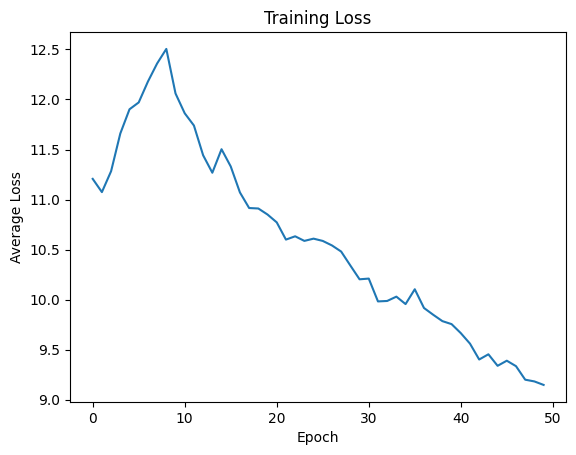

[11.206764221191406, 11.074341773986816, 11.28346061706543, 11.659832954406738, 11.902027130126953, 11.970460891723633, 12.178569793701172, 12.359564781188965, 12.50515365600586, 12.059968948364258, 11.862065315246582, 11.739714622497559, 11.44261360168457, 11.267913818359375, 11.502894401550293, 11.330678939819336, 11.070869445800781, 10.91533374786377, 10.910622596740723, 10.850193977355957, 10.771944046020508, 10.599846839904785, 10.63281536102295, 10.586869239807129, 10.609282493591309, 10.586503028869629, 10.541483879089355, 10.480284690856934, 10.340827941894531, 10.203099250793457, 10.210212707519531, 9.982073783874512, 9.986553192138672, 10.029820442199707, 9.955487251281738, 10.103639602661133, 9.916454315185547, 9.848913192749023, 9.785148620605469, 9.755192756652832, 9.665250778198242, 9.560112953186035, 9.401649475097656, 9.453680038452148, 9.3386812210083, 9.389656066894531, 9.335081100463867, 9.199950218200684, 9.182531356811523, 9.147647857666016]


In [ ]:
# Create the TransE model
transe = TransE(num_entities=num_entities, num_relations=num_relations, embedding_dim=20, learning_rate=0.01, margin=2.0, norm='l1')
# Train the model
transe.train(train,validation_triples=validation, num_epochs=50, batch_size=128)


Epoch 1/50, Batch 1/2437: average loss = 0.3522976040840149
Epoch 1/50, Batch 501/2437: average loss = 0.5324583649635315
Epoch 1/50, Batch 1001/2437: average loss = 0.5124881863594055
Epoch 1/50, Batch 1501/2437: average loss = 0.5082191824913025
Epoch 1/50, Batch 2001/2437: average loss = 0.46750131249427795
Epoch 1/50, Validation Loss = 9.168487548828125
Epoch 2/50, Batch 1/2437: average loss = 0.38904133439064026
Epoch 2/50, Batch 501/2437: average loss = 0.5467467308044434
Epoch 2/50, Batch 1001/2437: average loss = 0.43456923961639404
Epoch 2/50, Batch 1501/2437: average loss = 0.5100922584533691
Epoch 2/50, Batch 2001/2437: average loss = 0.4225078225135803
Epoch 2/50, Validation Loss = 9.047710418701172
Epoch 3/50, Batch 1/2437: average loss = 0.3992385268211365
Epoch 3/50, Batch 501/2437: average loss = 0.49104195833206177
Epoch 3/50, Batch 1001/2437: average loss = 0.516611635684967
Epoch 3/50, Batch 1501/2437: average loss = 0.5664301514625549
Epoch 3/50, Batch 2001/2437: av

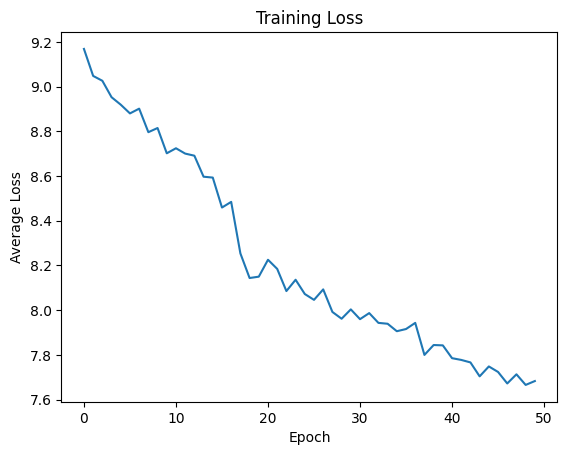

[9.168487548828125, 9.047710418701172, 9.025975227355957, 8.952500343322754, 8.919024467468262, 8.880019187927246, 8.901313781738281, 8.796095848083496, 8.814666748046875, 8.701641082763672, 8.724143028259277, 8.700318336486816, 8.690876007080078, 8.596900939941406, 8.59298324584961, 8.45902156829834, 8.484283447265625, 8.253861427307129, 8.143731117248535, 8.149801254272461, 8.225430488586426, 8.18458366394043, 8.085397720336914, 8.135994911193848, 8.072172164916992, 8.046059608459473, 8.092866897583008, 7.991927623748779, 7.9616007804870605, 8.003437995910645, 7.95970344543457, 7.986839771270752, 7.943069934844971, 7.939164161682129, 7.905757427215576, 7.915576457977295, 7.94304084777832, 7.799737930297852, 7.844019889831543, 7.842489719390869, 7.78519868850708, 7.77741003036499, 7.766201972961426, 7.703883647918701, 7.74821138381958, 7.723555088043213, 7.672083854675293, 7.713010787963867, 7.6655659675598145, 7.682908535003662]


In [ ]:
transe.train(train,validation_triples=validation, num_epochs=50, batch_size=128)

In [ ]:
# mount your Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# specify the path in your Drive
save_path = "/content/drive/MyDrive/"

# save the tensors
torch.save(transe.entity_embeddings, save_path + 'entity_embeddings.pt')
torch.save(transe.relation_embeddings, save_path + 'relation_embeddings.pt')

# load the tensors
entity_embeddings = torch.load(save_path + 'entity_embeddings.pt')
relation_embeddings = torch.load(save_path + 'relation_embeddings.pt')

Mounted at /content/drive


NameError: ignored

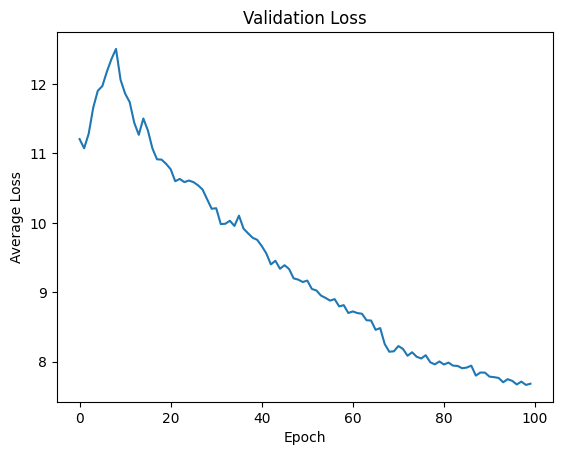

In [ ]:
epoch_losses = [11.206764221191406, 11.074341773986816, 11.28346061706543, 11.659832954406738, 11.902027130126953, 11.970460891723633, 12.178569793701172, 12.359564781188965, 12.50515365600586, 12.059968948364258, 11.862065315246582, 11.739714622497559, 11.44261360168457, 11.267913818359375, 11.502894401550293, 11.330678939819336, 11.070869445800781, 10.91533374786377, 10.910622596740723, 10.850193977355957, 10.771944046020508, 10.599846839904785, 10.63281536102295, 10.586869239807129, 10.609282493591309, 10.586503028869629, 10.541483879089355, 10.480284690856934, 10.340827941894531, 10.203099250793457, 10.210212707519531, 9.982073783874512, 9.986553192138672, 10.029820442199707, 9.955487251281738, 10.103639602661133, 9.916454315185547, 9.848913192749023, 9.785148620605469, 9.755192756652832, 9.665250778198242, 9.560112953186035, 9.401649475097656, 9.453680038452148, 9.3386812210083, 9.389656066894531, 9.335081100463867, 9.199950218200684, 9.182531356811523, 9.147647857666016, 9.168487548828125, 9.047710418701172, 9.025975227355957, 8.952500343322754, 8.919024467468262, 8.880019187927246, 8.901313781738281, 8.796095848083496, 8.814666748046875, 8.701641082763672, 8.724143028259277, 8.700318336486816, 8.690876007080078, 8.596900939941406, 8.59298324584961, 8.45902156829834, 8.484283447265625, 8.253861427307129, 8.143731117248535, 8.149801254272461, 8.225430488586426, 8.18458366394043, 8.085397720336914, 8.135994911193848, 8.072172164916992, 8.046059608459473, 8.092866897583008, 7.991927623748779, 7.9616007804870605, 8.003437995910645, 7.95970344543457, 7.986839771270752, 7.943069934844971, 7.939164161682129, 7.905757427215576, 7.915576457977295, 7.94304084777832, 7.799737930297852, 7.844019889831543, 7.842489719390869, 7.78519868850708, 7.77741003036499, 7.766201972961426, 7.703883647918701, 7.74821138381958, 7.723555088043213, 7.672083854675293, 7.713010787963867, 7.6655659675598145, 7.682908535003662]
plt.plot(epoch_losses)
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('Validation Loss')
plt.show()

In [ ]:
transe.device = device = torch.device("cpu")

mean_rank_raw, hits_at_10_raw = transe.raw_test(test)
print(f'Raw test results: Mean Rank = {mean_rank_raw}, Hits@10 = {hits_at_10_raw}')

mean_rank_filt, hits_at_10_filt = transe.filtered_test(test, indexed_relations)
print(f'Filtered test results: Mean Rank = {mean_rank_filt}, Hits@10 = {hits_at_10_filt}')



Raw test results: Mean Rank = 57110.75683975433, Hits@10 = 0.006141820212171971


AttributeError: ignored

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# specify the path in your Drive
save_path = "/content/drive/MyDrive/fb15k/"

Mounted at /content/drive


In [ ]:
def load_data(file_path, entity_vocab, relation_vocab):
    with open(file_path, 'r') as f:
        data = f.read().splitlines()
    return [(entity_vocab[line.split()[0]], relation_vocab[line.split()[2]], entity_vocab[line.split()[1]]) for line in data]

def load_vocab(file_path):
    with open(file_path, 'r') as f:
        data = f.read().splitlines()
    return {line.split()[0]: int(line.split()[1]) for line in data}

# Load vocabularies
entity_vocab = load_vocab(save_path + 'entity2id.txt')
relation_vocab = load_vocab(save_path + 'relation2id.txt')


# Load data
train_data = load_data(save_path + 'train.txt', entity_vocab, relation_vocab)
valid_data = load_data(save_path + 'valid.txt', entity_vocab, relation_vocab)
test_data = load_data(save_path + 'test.txt', entity_vocab, relation_vocab)

# Initialize the model
num_entities = len(entity_vocab)
num_relations = len(relation_vocab)

print(num_entities, num_relations, len(train_data), len(valid_data), len(test_data))


14951 1345 483142 50000 59071


Epoch 1/50, Batch 1/3775: average loss = 1.7070059776306152
Epoch 1/50, Batch 501/3775: average loss = 0.8408200740814209
Epoch 1/50, Batch 1001/3775: average loss = 0.7815908193588257
Epoch 1/50, Batch 1501/3775: average loss = 0.5818048715591431
Epoch 1/50, Batch 2001/3775: average loss = 0.4464329183101654
Epoch 1/50, Batch 2501/3775: average loss = 0.4066131114959717
Epoch 1/50, Batch 3001/3775: average loss = 0.3303574025630951
Epoch 1/50, Batch 3501/3775: average loss = 0.22741439938545227
Epoch 1/50, Validation Loss = -0.9068824052810669
Epoch 2/50, Batch 1/3775: average loss = 0.21658197045326233
Epoch 2/50, Batch 501/3775: average loss = 0.16493991017341614
Epoch 2/50, Batch 1001/3775: average loss = 0.299286425113678
Epoch 2/50, Batch 1501/3775: average loss = 0.1281975656747818
Epoch 2/50, Batch 2001/3775: average loss = 0.2149263322353363
Epoch 2/50, Batch 2501/3775: average loss = 0.12976229190826416
Epoch 2/50, Batch 3001/3775: average loss = 0.16716600954532623
Epoch 2/5

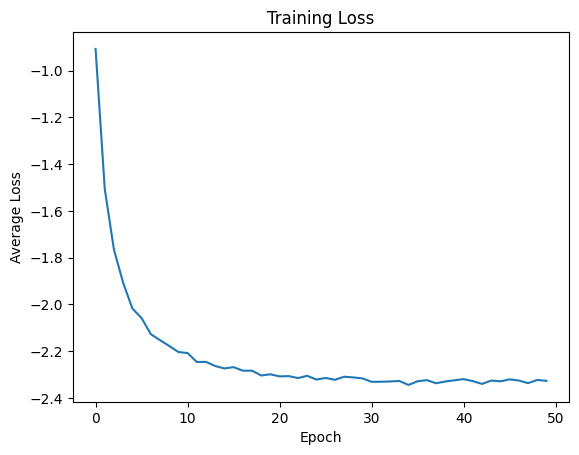

[-0.9068824052810669, -1.5067740678787231, -1.766127347946167, -1.9079270362854004, -2.0174171924591064, -2.058310031890869, -2.12725567817688, -2.1527016162872314, -2.177852153778076, -2.203544855117798, -2.2080113887786865, -2.246227502822876, -2.2457773685455322, -2.263544797897339, -2.273815155029297, -2.26835560798645, -2.283510684967041, -2.283370018005371, -2.3039944171905518, -2.298919677734375, -2.3077774047851562, -2.3067610263824463, -2.3150503635406494, -2.3052961826324463, -2.3214592933654785, -2.3145463466644287, -2.322341203689575, -2.30942440032959, -2.3122191429138184, -2.316516399383545, -2.331096887588501, -2.3308379650115967, -2.3294873237609863, -2.3274505138397217, -2.344365119934082, -2.328587770462036, -2.3239240646362305, -2.337299108505249, -2.3296892642974854, -2.324550151824951, -2.319486141204834, -2.328188180923462, -2.340073585510254, -2.325807809829712, -2.328913688659668, -2.320611000061035, -2.3256349563598633, -2.336799144744873, -2.3230695724487305, 

In [ ]:
transe = TransE(num_entities=num_entities, num_relations=num_relations, embedding_dim=50, learning_rate=0.01, margin=1.0, norm='l1')
transe.train(train_data, validation_triples=valid_data, num_epochs=50, batch_size=128)

[-0.9068824052810669,-1.5067740678787231,  -1.766127347946167, -1.9079270362854004,-2.0174171924591064, -2.058310031890869,  -2.12725567817688,  -2.1527016162872314, -2.177852153778076, -2.203544855117798, -2.2080113887786865, -2.246227502822876,
 -2.2457773685455322,
 ]

Epoch 1/50, Batch 1/3775: average loss = 0.3912067115306854
Epoch 1/50, Batch 501/3775: average loss = 0.390889972448349
Epoch 1/50, Batch 1001/3775: average loss = 0.31614503264427185
Epoch 1/50, Batch 1501/3775: average loss = 0.26809149980545044
Epoch 1/50, Batch 2001/3775: average loss = 0.4182451665401459
Epoch 1/50, Batch 2501/3775: average loss = 0.28904440999031067
Epoch 1/50, Batch 3001/3775: average loss = 0.34703582525253296
Epoch 1/50, Batch 3501/3775: average loss = 0.3338848948478699
Epoch 1/50, Validation Loss = 7.983285903930664
Epoch 2/50, Batch 1/3775: average loss = 0.3793700933456421
Epoch 2/50, Batch 501/3775: average loss = 0.29784339666366577
Epoch 2/50, Batch 1001/3775: average loss = 0.35851752758026123
Epoch 2/50, Batch 1501/3775: average loss = 0.30860233306884766
Epoch 2/50, Batch 2001/3775: average loss = 0.2948279082775116
Epoch 2/50, Batch 2501/3775: average loss = 0.3366028666496277
Epoch 2/50, Batch 3001/3775: average loss = 0.30983036756515503
Epoch 2/

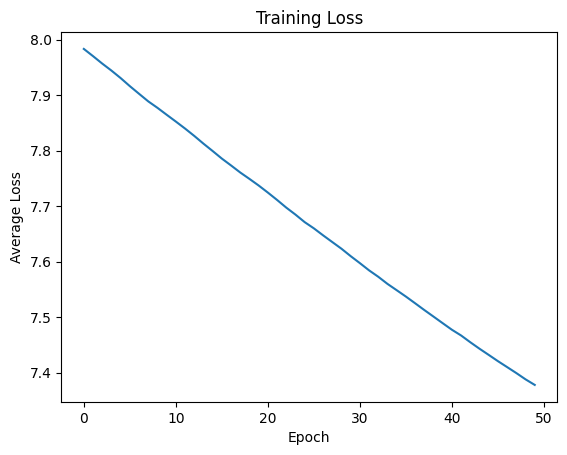

[7.983285903930664, 7.970285892486572, 7.9568705558776855, 7.944261074066162, 7.930760860443115, 7.916220188140869, 7.902462482452393, 7.888799667358398, 7.877171039581299, 7.864694595336914, 7.85240364074707, 7.839816570281982, 7.826564788818359, 7.81261682510376, 7.799315929412842, 7.78566837310791, 7.773321151733398, 7.76060676574707, 7.749091148376465, 7.737203598022461, 7.724443435668945, 7.711177349090576, 7.697353363037109, 7.684764385223389, 7.671212196350098, 7.659983158111572, 7.647434711456299, 7.635321140289307, 7.623266220092773, 7.609918594360352, 7.5973124504089355, 7.584299087524414, 7.572737216949463, 7.559913635253906, 7.548544883728027, 7.537087917327881, 7.525043964385986, 7.512845993041992, 7.501023769378662, 7.489104747772217, 7.477301597595215, 7.466969966888428, 7.454774856567383, 7.44310998916626, 7.431993007659912, 7.4207305908203125, 7.410037517547607, 7.39927339553833, 7.38797664642334, 7.377914905548096]


In [ ]:
transe.train(train_data, validation_triples=valid_data, num_epochs=50, batch_size=128)

Epoch 1/100, Batch 1/3775: average loss = 0.1878242790699005
Epoch 1/100, Batch 501/3775: average loss = 0.18339943885803223
Epoch 1/100, Batch 1001/3775: average loss = 0.10991952568292618
Epoch 1/100, Batch 1501/3775: average loss = 0.15411534905433655
Epoch 1/100, Batch 2001/3775: average loss = 0.19074147939682007
Epoch 1/100, Batch 2501/3775: average loss = 0.17794309556484222
Epoch 1/100, Batch 3001/3775: average loss = 0.11613324284553528
Epoch 1/100, Batch 3501/3775: average loss = 0.12475933879613876
Epoch 1/100, Validation Loss = 7.366307258605957
Epoch 2/100, Batch 1/3775: average loss = 0.1573261320590973
Epoch 2/100, Batch 501/3775: average loss = 0.20336782932281494
Epoch 2/100, Batch 1001/3775: average loss = 0.20808205008506775
Epoch 2/100, Batch 1501/3775: average loss = 0.09706547856330872
Epoch 2/100, Batch 2001/3775: average loss = 0.21132200956344604
Epoch 2/100, Batch 2501/3775: average loss = 0.19066430628299713
Epoch 2/100, Batch 3001/3775: average loss = 0.1561

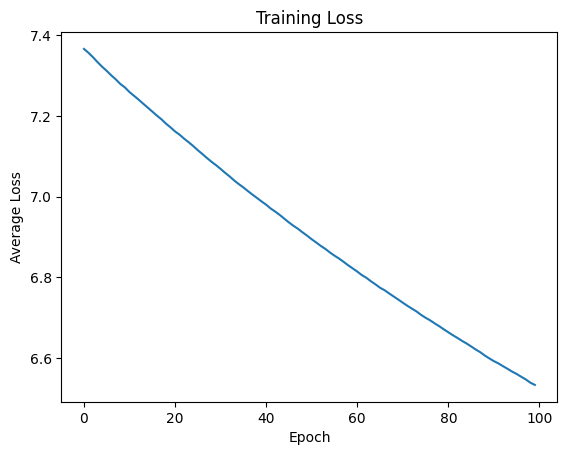

[7.366307258605957, 7.356629848480225, 7.345520496368408, 7.33329439163208, 7.322035312652588, 7.311818599700928, 7.300716876983643, 7.290643692016602, 7.279241561889648, 7.2706780433654785, 7.2592902183532715, 7.249910354614258, 7.24054479598999, 7.2305474281311035, 7.220822334289551, 7.210962295532227, 7.20107364654541, 7.191812992095947, 7.181084156036377, 7.171810626983643, 7.161614894866943, 7.153475284576416, 7.143611907958984, 7.13472843170166, 7.125324726104736, 7.115041732788086, 7.105530261993408, 7.0957183837890625, 7.086410999298096, 7.077928066253662, 7.068697452545166, 7.05886173248291, 7.0498528480529785, 7.039829730987549, 7.030923366546631, 7.0227508544921875, 7.0135884284973145, 7.00484561920166, 6.99647855758667, 6.987911224365234, 6.979865550994873, 6.970345497131348, 6.962702751159668, 6.954326152801514, 6.945089340209961, 6.935873985290527, 6.927484035491943, 6.919976711273193, 6.911176681518555, 6.9030256271362305, 6.89414119720459, 6.886031150817871, 6.877560615

In [ ]:
transe.train(train_data, validation_triples=valid_data, num_epochs=100, batch_size=128)

In [ ]:
# mount your Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# specify the path in your Drive
save_path = "/content/drive/MyDrive/"

# save the tensors
torch.save(transe.entity_embeddings, save_path + 'fentity_embeddings.pt')
torch.save(transe.relation_embeddings, save_path + 'frelation_embeddings.pt')


Mounted at /content/drive


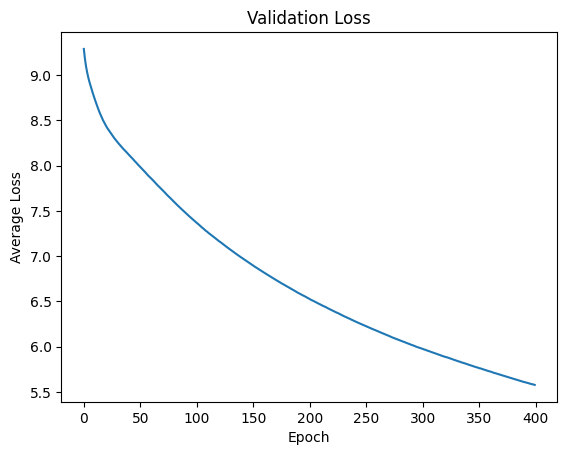

In [ ]:
epoch_losses =[9.287312507629395, 9.176071166992188, 9.091182708740234, 9.025002479553223, 8.96970272064209, 8.921310424804688, 8.87841510772705, 8.837596893310547, 8.796592712402344, 8.757943153381348, 8.721755027770996, 8.684663772583008, 8.650642395019531, 8.61757755279541, 8.584147453308105, 8.556295394897461, 8.527681350708008, 8.499792098999023, 8.476134300231934, 8.453848838806152, 8.430014610290527, 8.40948486328125, 8.391473770141602, 8.37170696258545, 8.354116439819336, 8.337448120117188, 8.320103645324707, 8.301733016967773, 8.286046981811523, 8.270651817321777, 8.254701614379883, 8.239904403686523, 8.22614860534668, 8.212590217590332, 8.197391510009766, 8.182596206665039, 8.170576095581055, 8.157539367675781, 8.143720626831055, 8.130570411682129, 8.116893768310547, 8.10422134399414, 8.09018325805664, 8.077479362487793, 8.064282417297363, 8.04885196685791, 8.03683853149414, 8.022469520568848, 8.008994102478027, 7.996100425720215, 7.983285903930664,
               7.970285892486572, 7.9568705558776855, 7.944261074066162, 7.930760860443115, 7.916220188140869, 7.902462482452393, 7.888799667358398, 7.877171039581299, 7.864694595336914, 7.85240364074707, 7.839816570281982, 7.826564788818359, 7.81261682510376, 7.799315929412842, 7.78566837310791, 7.773321151733398, 7.76060676574707,
               7.749091148376465, 7.737203598022461, 7.724443435668945, 7.711177349090576, 7.697353363037109, 7.684764385223389, 7.671212196350098, 7.659983158111572, 7.647434711456299, 7.635321140289307, 7.623266220092773, 7.609918594360352, 7.5973124504089355, 7.584299087524414, 7.572737216949463, 7.559913635253906,
               7.548544883728027, 7.537087917327881, 7.525043964385986, 7.512845993041992, 7.501023769378662, 7.489104747772217, 7.477301597595215, 7.466969966888428, 7.454774856567383, 7.44310998916626, 7.431993007659912, 7.4207305908203125, 7.410037517547607, 7.39927339553833, 7.38797664642334, 7.377914905548096,
               7.366307258605957, 7.356629848480225, 7.345520496368408, 7.33329439163208, 7.322035312652588, 7.311818599700928, 7.300716876983643, 7.290643692016602, 7.279241561889648, 7.2706780433654785, 7.2592902183532715, 7.249910354614258, 7.24054479598999, 7.2305474281311035, 7.220822334289551, 7.210962295532227, 7.20107364654541, 7.191812992095947, 7.181084156036377, 7.171810626983643, 7.161614894866943, 7.153475284576416, 7.143611907958984, 7.13472843170166, 7.125324726104736, 7.115041732788086, 7.105530261993408, 7.0957183837890625, 7.086410999298096, 7.077928066253662, 7.068697452545166, 7.05886173248291, 7.0498528480529785, 7.039829730987549, 7.030923366546631, 7.0227508544921875, 7.0135884284973145, 7.00484561920166, 6.99647855758667, 6.987911224365234, 6.979865550994873, 6.970345497131348, 6.962702751159668, 6.954326152801514, 6.945089340209961, 6.935873985290527, 6.927484035491943, 6.919976711273193, 6.911176681518555, 6.9030256271362305, 6.89414119720459, 6.886031150817871, 6.877560615539551, 6.870189666748047, 6.8613667488098145, 6.853433609008789, 6.846314907073975, 6.838178634643555, 6.829587936401367, 6.821879863739014, 6.81396484375, 6.8053083419799805, 6.79852294921875, 6.7899298667907715, 6.782256126403809, 6.773865222930908, 6.767700672149658, 6.759756088256836, 6.752121925354004, 6.744585037231445, 6.736724376678467, 6.729126930236816, 6.722035884857178, 6.715122222900391, 6.7066497802734375, 6.699390411376953, 6.693009853363037, 6.68544340133667, 6.6783928871154785, 6.670682907104492, 6.6633405685424805, 6.655994892120361, 6.649321556091309, 6.642056941986084, 6.635541915893555, 6.6282548904418945, 6.620709419250488, 6.613980293273926, 6.605690002441406, 6.598535060882568, 6.591749668121338, 6.586097240447998, 6.579228401184082, 6.572702884674072, 6.565773010253906, 6.559901237487793, 6.552998065948486, 6.546414375305176, 6.538360595703125, 6.532712936401367,
               6.524714946746826, 6.517858505249023, 6.51252555847168, 6.506345272064209, 6.499682903289795, 6.4937052726745605, 6.487048625946045, 6.479759693145752, 6.4737067222595215, 6.468066692352295, 6.4607648849487305, 6.454713821411133, 6.449396133422852, 6.4441142082214355, 6.437960624694824, 6.430428504943848, 6.423818588256836, 6.417722225189209, 6.411111831665039, 6.405276298522949, 6.398947238922119, 6.39381742477417, 6.387027740478516, 6.380573749542236, 6.374845027923584, 6.370322227478027, 6.3636555671691895, 6.3568525314331055, 6.351449012756348, 6.344635009765625, 6.337972164154053, 6.332819938659668, 6.326701641082764, 6.321532249450684, 6.314663410186768, 6.310392379760742, 6.303328514099121, 6.29741096496582, 6.291490077972412, 6.286727428436279, 6.28020715713501, 6.274881839752197, 6.269059181213379, 6.262996673583984, 6.257443428039551, 6.252635955810547, 6.24622106552124, 6.241806507110596, 6.2347893714904785, 6.2297749519348145, 6.225071907043457, 6.218405246734619, 6.2125396728515625, 6.2079949378967285, 6.202275276184082, 6.197602272033691, 6.192564964294434, 6.187364101409912, 6.18254280090332, 6.1771240234375, 6.171858787536621, 6.165527820587158, 6.160515308380127, 6.155510902404785, 6.15017032623291, 6.144199371337891, 6.1397271156311035, 6.1347150802612305, 6.129177570343018, 6.124311923980713, 6.119119167327881, 6.11367654800415, 6.108120918273926, 6.101998805999756, 6.0975341796875, 6.093051910400391, 6.0888848304748535, 6.083037376403809, 6.078136920928955, 6.073011875152588, 6.067913055419922, 6.062746047973633, 6.058255672454834, 6.053487777709961, 6.048776149749756, 6.044153690338135, 6.039055347442627, 6.034739971160889, 6.029530048370361, 6.024260997772217, 6.01979398727417, 6.015326499938965, 6.011714458465576, 6.005640029907227, 6.000420570373535, 5.996321201324463, 5.992369651794434, 5.987272262573242, 5.983964443206787, 5.980018138885498,
               5.975421905517578, 5.96973991394043, 5.966737270355225, 5.961764335632324, 5.956291198730469, 5.952374458312988, 5.949044227600098, 5.943451881408691, 5.939420700073242, 5.935096263885498, 5.930634021759033, 5.9263153076171875, 5.921534061431885, 5.917751312255859, 5.912746906280518, 5.908939361572266, 5.9031500816345215, 5.898683071136475, 5.895225524902344, 5.890331745147705, 5.887579441070557, 5.884035587310791, 5.879919052124023, 5.875744819641113, 5.870960712432861, 5.867187976837158, 5.862006664276123, 5.857714653015137, 5.853761672973633, 5.84972620010376, 5.845029830932617, 5.840911865234375, 5.836122512817383, 5.8335161209106445, 5.8278398513793945, 5.824281692504883, 5.8205246925354, 5.816545486450195, 5.812223434448242, 5.80797004699707, 5.8040971755981445, 5.799355983734131, 5.795206069946289, 5.789865016937256, 5.785589694976807, 5.782257556915283, 5.778316497802734, 5.774401664733887, 5.771626949310303, 5.767160415649414, 5.762813568115234, 5.760223388671875, 5.756025314331055, 5.751905918121338, 5.748101234436035, 5.743947505950928, 5.740114688873291, 5.736236095428467, 5.73129940032959, 5.72852087020874, 5.724797248840332, 5.719448566436768, 5.715409755706787, 5.711967945098877, 5.7092766761779785, 5.704040050506592, 5.70018196105957, 5.696813106536865, 5.693342208862305, 5.689047813415527, 5.684031009674072, 5.681182384490967, 5.676379203796387, 5.6732048988342285, 5.669280052185059, 5.665583610534668, 5.660800457000732, 5.657771587371826, 5.652920246124268, 5.64888858795166, 5.645135402679443, 5.641963481903076, 5.638192176818848, 5.634598731994629, 5.631586074829102, 5.626946926116943, 5.62308406829834, 5.618363380432129, 5.615436553955078, 5.612020492553711, 5.609139919281006, 5.6061110496521, 5.602963447570801, 5.599244117736816, 5.59505033493042, 5.591097831726074, 5.588442802429199, 5.584697246551514, 5.582307815551758, 5.578065872192383,
               ]
plt.plot(epoch_losses)
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('Validation Loss')
plt.show()

In [ ]:
transe = TransE(num_entities=num_entities, num_relations=num_relations, embedding_dim=50, learning_rate=0.01, margin=1.0, norm='l1')


drive.mount('/content/drive', force_remount=True)

# specify the path in your Drive
save_path = "/content/drive/MyDrive/"

# entity_embeddings = torch.load(save_path + 'fentity_embeddings.pt')
# relation_embeddings = torch.load(save_path + 'frelation_embeddings.pt')

# transe.entity_embeddings = entity_embeddings
# transe.relation_embeddings = entity_embeddings

transe.train(train_data, validation_triples=valid_data, num_epochs=100, batch_size=128)





Mounted at /content/drive
Epoch 1/100, Batch 1/3775: average loss = 1.0451070070266724
Epoch 1/100, Batch 501/3775: average loss = 1.064008116722107
Epoch 1/100, Batch 1001/3775: average loss = 1.0702550411224365
Epoch 1/100, Batch 1501/3775: average loss = 1.0465751886367798
Epoch 1/100, Batch 2001/3775: average loss = 0.8879718780517578
Epoch 1/100, Batch 2501/3775: average loss = 1.0146706104278564
Epoch 1/100, Batch 3001/3775: average loss = 0.9239103198051453
Epoch 1/100, Batch 3501/3775: average loss = 0.9297354221343994
Epoch 1/100, Validation Loss = 9.283893585205078
Epoch 2/100, Batch 1/3775: average loss = 0.866880476474762
Epoch 2/100, Batch 501/3775: average loss = 0.960290253162384


KeyboardInterrupt: ignored

Mounted at /content/drive
Epoch 1/100, Batch 1/3775: average loss = 0.06317837536334991
Epoch 1/100, Batch 501/3775: average loss = 0.08106988668441772
Epoch 1/100, Batch 1001/3775: average loss = 0.04323409125208855
Epoch 1/100, Batch 1501/3775: average loss = 0.17169176042079926
Epoch 1/100, Batch 2001/3775: average loss = 0.1286071538925171
Epoch 1/100, Batch 2501/3775: average loss = 0.11050044000148773
Epoch 1/100, Batch 3001/3775: average loss = 0.1261664628982544
Epoch 1/100, Batch 3501/3775: average loss = 0.06685608625411987
Epoch 1/100, Validation Loss = 6.524714946746826
Epoch 2/100, Batch 1/3775: average loss = 0.16678938269615173
Epoch 2/100, Batch 501/3775: average loss = 0.05672809109091759
Epoch 2/100, Batch 1001/3775: average loss = 0.14367681741714478
Epoch 2/100, Batch 1501/3775: average loss = 0.0831356942653656
Epoch 2/100, Batch 2001/3775: average loss = 0.12134576588869095
Epoch 2/100, Batch 2501/3775: average loss = 0.08621178567409515
Epoch 2/100, Batch 3001/37

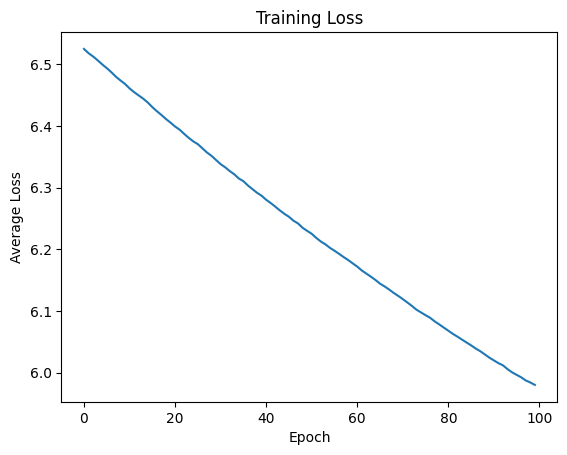

[6.524714946746826, 6.517858505249023, 6.51252555847168, 6.506345272064209, 6.499682903289795, 6.4937052726745605, 6.487048625946045, 6.479759693145752, 6.4737067222595215, 6.468066692352295, 6.4607648849487305, 6.454713821411133, 6.449396133422852, 6.4441142082214355, 6.437960624694824, 6.430428504943848, 6.423818588256836, 6.417722225189209, 6.411111831665039, 6.405276298522949, 6.398947238922119, 6.39381742477417, 6.387027740478516, 6.380573749542236, 6.374845027923584, 6.370322227478027, 6.3636555671691895, 6.3568525314331055, 6.351449012756348, 6.344635009765625, 6.337972164154053, 6.332819938659668, 6.326701641082764, 6.321532249450684, 6.314663410186768, 6.310392379760742, 6.303328514099121, 6.29741096496582, 6.291490077972412, 6.286727428436279, 6.28020715713501, 6.274881839752197, 6.269059181213379, 6.262996673583984, 6.257443428039551, 6.252635955810547, 6.24622106552124, 6.241806507110596, 6.2347893714904785, 6.2297749519348145, 6.225071907043457, 6.218405246734619, 6.212539

In [ ]:

drive.mount('/content/drive', force_remount=True)

# specify the path in your Drive
save_path = "/content/drive/MyDrive/"

entity_embeddings = torch.load(save_path + 'fentity_embeddings.pt')
relation_embeddings = torch.load(save_path + 'frelation_embeddings.pt')

transe.entity_embeddings = entity_embeddings
transe.relation_embeddings = relation_embeddings

transe.train(train_data, validation_triples=valid_data, num_epochs=100, batch_size=128)

In [ ]:
# save the tensors
torch.save(transe.entity_embeddings, save_path + 'fentity_embeddings1.pt')
torch.save(transe.relation_embeddings, save_path + 'frelation_embeddings1.pt')
transe.train(train_data, validation_triples=valid_data, num_epochs=200, batch_size=128)


Epoch 1/200, Batch 1/3775: average loss = 0.09749013185501099
Epoch 1/200, Batch 501/3775: average loss = 0.062386151403188705
Epoch 1/200, Batch 1001/3775: average loss = 0.0539325587451458
Epoch 1/200, Batch 1501/3775: average loss = 0.07852214574813843
Epoch 1/200, Batch 2001/3775: average loss = 0.07665431499481201
Epoch 1/200, Batch 2501/3775: average loss = 0.06778678297996521
Epoch 1/200, Batch 3001/3775: average loss = 0.06941104680299759
Epoch 1/200, Batch 3501/3775: average loss = 0.11414696276187897
Epoch 1/200, Validation Loss = 5.974772930145264
Epoch 2/200, Batch 1/3775: average loss = 0.049133069813251495
Epoch 2/200, Batch 501/3775: average loss = 0.09107784926891327
Epoch 2/200, Batch 1001/3775: average loss = 0.08265284448862076
Epoch 2/200, Batch 1501/3775: average loss = 0.03894410282373428
Epoch 2/200, Batch 2001/3775: average loss = 0.10371655225753784
Epoch 2/200, Batch 2501/3775: average loss = 0.1472945660352707
Epoch 2/200, Batch 3001/3775: average loss = 0.09

Mounted at /content/drive
Epoch 1/100, Batch 1/3775: average loss = 0.08685631304979324
Epoch 1/100, Batch 501/3775: average loss = 0.1336115449666977
Epoch 1/100, Batch 1001/3775: average loss = 0.09823720157146454
Epoch 1/100, Batch 1501/3775: average loss = 0.05090048536658287
Epoch 1/100, Batch 2001/3775: average loss = 0.0451732762157917
Epoch 1/100, Batch 2501/3775: average loss = 0.12302993983030319
Epoch 1/100, Batch 3001/3775: average loss = 0.07434786856174469
Epoch 1/100, Batch 3501/3775: average loss = 0.08353842794895172
Epoch 1/100, Validation Loss = 5.975421905517578
Epoch 2/100, Batch 1/3775: average loss = 0.06013450771570206
Epoch 2/100, Batch 501/3775: average loss = 0.07262852787971497
Epoch 2/100, Batch 1001/3775: average loss = 0.1443464308977127
Epoch 2/100, Batch 1501/3775: average loss = 0.04927567020058632
Epoch 2/100, Batch 2001/3775: average loss = 0.07895956933498383
Epoch 2/100, Batch 2501/3775: average loss = 0.08918626606464386
Epoch 2/100, Batch 3001/37

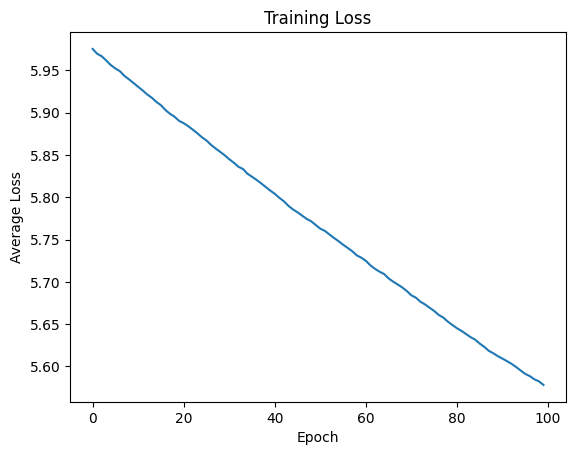

[5.975421905517578, 5.96973991394043, 5.966737270355225, 5.961764335632324, 5.956291198730469, 5.952374458312988, 5.949044227600098, 5.943451881408691, 5.939420700073242, 5.935096263885498, 5.930634021759033, 5.9263153076171875, 5.921534061431885, 5.917751312255859, 5.912746906280518, 5.908939361572266, 5.9031500816345215, 5.898683071136475, 5.895225524902344, 5.890331745147705, 5.887579441070557, 5.884035587310791, 5.879919052124023, 5.875744819641113, 5.870960712432861, 5.867187976837158, 5.862006664276123, 5.857714653015137, 5.853761672973633, 5.84972620010376, 5.845029830932617, 5.840911865234375, 5.836122512817383, 5.8335161209106445, 5.8278398513793945, 5.824281692504883, 5.8205246925354, 5.816545486450195, 5.812223434448242, 5.80797004699707, 5.8040971755981445, 5.799355983734131, 5.795206069946289, 5.789865016937256, 5.785589694976807, 5.782257556915283, 5.778316497802734, 5.774401664733887, 5.771626949310303, 5.767160415649414, 5.762813568115234, 5.760223388671875, 5.756025314

In [ ]:
drive.mount('/content/drive', force_remount=True)
transe = TransE(num_entities=num_entities, num_relations=num_relations, embedding_dim=50, learning_rate=0.01, margin=1.0, norm='l1')

# specify the path in your Drive
save_path = "/content/drive/MyDrive/"

entity_embeddings = torch.load(save_path + 'fentity_embeddings1.pt')
relation_embeddings = torch.load(save_path + 'frelation_embeddings1.pt')

transe.entity_embeddings = entity_embeddings
transe.relation_embeddings = relation_embeddings

transe.train(train_data, validation_triples=valid_data, num_epochs=100, batch_size=128)

In [ ]:
torch.save(transe.entity_embeddings, save_path + 'fentity_embeddings2.pt')
torch.save(transe.relation_embeddings, save_path + 'frelation_embeddings2.pt')




In [ ]:
transe = TransE(num_entities=num_entities, num_relations=num_relations, embedding_dim=50, learning_rate=0.01, margin=1.0, norm='l1')

transe.train(train_data, validation_triples=valid_data, num_epochs=100, batch_size=128)
torch.save(transe.entity_embeddings, save_path + 'fentity_embeddings3.pt')
torch.save(transe.relation_embeddings, save_path + 'frelation_embeddings3.pt')

Epoch 1/100, Batch 1/3775: average loss = 1.0866087675094604
Epoch 1/100, Batch 501/3775: average loss = 0.7003790736198425
Epoch 1/100, Batch 1001/3775: average loss = 0.5121863484382629
Epoch 1/100, Batch 1501/3775: average loss = 0.3837413489818573
Epoch 1/100, Batch 2001/3775: average loss = 0.28157052397727966
Epoch 1/100, Batch 2501/3775: average loss = 0.2672230005264282
Epoch 1/100, Batch 3001/3775: average loss = 0.1910059005022049
Epoch 1/100, Batch 3501/3775: average loss = 0.10850880295038223
Epoch 1/100, Validation Loss = 8.108722686767578
Epoch 2/100, Batch 1/3775: average loss = 0.24802476167678833
Epoch 2/100, Batch 501/3775: average loss = 0.11237937957048416
Epoch 2/100, Batch 1001/3775: average loss = 0.16250625252723694
Epoch 2/100, Batch 1501/3775: average loss = 0.1291683316230774
Epoch 2/100, Batch 2001/3775: average loss = 0.07732220739126205
Epoch 2/100, Batch 2501/3775: average loss = 0.1993555724620819
Epoch 2/100, Batch 3001/3775: average loss = 0.4483503103

KeyboardInterrupt: ignored

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn

class TransE:
    def __init__(self, num_entities, num_relations, embedding_dim=100, learning_rate=0.01, margin=1.0, norm='l2'):
        self.num_entities = num_entities
        self.num_relations = num_relations
        self.embedding_dim = embedding_dim
        self.learning_rate = learning_rate
        self.margin = margin
        self.norm = norm

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Initialize entity and relation embeddings
        self.entity_embeddings = torch.nn.Embedding(num_entities, embedding_dim).to(self.device)
        self.relation_embeddings = torch.nn.Embedding(num_relations, embedding_dim).to(self.device)

        torch.nn.init.uniform_(self.entity_embeddings.weight, -6/np.sqrt(embedding_dim), 6/np.sqrt(embedding_dim))
        torch.nn.init.uniform_(self.relation_embeddings.weight, -6/np.sqrt(embedding_dim), 6/np.sqrt(embedding_dim))

        self.relation_embeddings.weight.data.div_(self.relation_embeddings.weight.data.norm(p=2, dim=1, keepdim=True))


    def forward(self, triplets):
        heads = self.entity_embeddings(triplets[:, 0])
        relations = self.relation_embeddings(triplets[:, 1])
        tails = self.entity_embeddings(triplets[:, 2])

        if self.norm == 'l1':
          return torch.norm(heads + relations - tails, p=1, dim=1)
        else:
          return torch.norm(heads + relations - tails, p=2, dim=1)


    def score(self, triple):
        head, relation, tail = triple
        head_embedding = self.entity_embeddings(torch.tensor([head]).to(self.device))
        relation_embedding = self.relation_embeddings(torch.tensor([relation]).to(self.device))
        tail_embedding = self.entity_embeddings(torch.tensor([tail]).to(self.device))

        if self.norm == 'l1':
            score = torch.norm(head_embedding + relation_embedding - tail_embedding, p=1)
        else:
            score = torch.norm(head_embedding + relation_embedding - tail_embedding, p=2)
        return score

    def train(self, triples, num_epochs, validation_triples=None, batch_size=128):
        epoch_losses = []

        optimizer = torch.optim.Adam(list(self.entity_embeddings.parameters()) + list(self.relation_embeddings.parameters()), lr=self.learning_rate)
        criterion = torch.nn.MarginRankingLoss(margin=self.margin)

        triples = torch.tensor(triples, dtype=torch.long, device=self.device)
        if validation_triples is not None:
            validation_triples = torch.tensor(validation_triples, dtype=torch.long, device=self.device)

        num_batches = len(triples) // batch_size
        if len(triples) % batch_size != 0:
            num_batches += 1

        for epoch in range(num_epochs):
            triples = triples[torch.randperm(triples.size()[0])]
            self.entity_embeddings.weight.data = nn.functional.normalize(self.entity_embeddings.weight.data, p=2, dim=1)
            for batch_num in range(num_batches):
                batch_start = batch_num * batch_size
                batch_end = (batch_num + 1) * batch_size
                batch_triples = triples[batch_start:batch_end]

                optimizer.zero_grad()

                pos_scores = self.forward(batch_triples)
                neg_triples = batch_triples.clone()
                rand_entities = torch.randint(self.num_entities, (len(neg_triples),)).to(self.device)

                replace_heads = (torch.rand(len(neg_triples)) > 0.5).to(self.device)
                neg_triples[replace_heads, 0] = rand_entities[replace_heads]
                neg_triples[~replace_heads, 2] = rand_entities[~replace_heads]
                neg_scores = self.forward(neg_triples)

                y = torch.ones_like(pos_scores).to(self.device)
                loss = criterion(pos_scores, neg_scores, y)

                loss.backward()
                optimizer.step()


                if (batch_num % 500 == 0):
                    print(f'Epoch {epoch+1}/{num_epochs}, Batch {batch_num+1}/{num_batches}: average loss = {loss.item()}')

            if validation_triples is not None:
                with torch.no_grad():
                    pos_scores = self.forward(validation_triples)
                    neg_triples = validation_triples.clone()
                    rand_entities = torch.randint(self.num_entities, (len(neg_triples),)).to(self.device)
                    if self.norm == 'l1':
                        replace_heads = (torch.rand(len(neg_triples)) > 0.5).to(self.device)
                    else:
                        replace_heads = (torch.rand(len(neg_triples)) > 0.5).to(self.device)
                    neg_triples[replace_heads, 0] = rand_entities[replace_heads]
                    neg_triples[~replace_heads, 2] = rand_entities[~replace_heads]
                    neg_scores = self.forward(neg_triples)

                    y = torch.ones_like(pos_scores).to(self.device)
                    validation_loss = criterion(pos_scores, neg_scores, y)
                    validation_loss = validation_loss.item()
                    epoch_losses.append(validation_loss)
                    print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss = {validation_loss}')

        plt.plot(epoch_losses)
        plt.xlabel('Epoch')
        plt.ylabel('Average Loss')
        plt.title('Training Loss')
        plt.show()
        print(epoch_losses)



    def score2(self, triples):
      heads, relations, tails = triples[:, 0], triples[:, 1], triples[:, 2]
      head_embeddings = self.entity_embeddings(heads)
      relation_embeddings = self.relation_embeddings(relations)
      tail_embeddings = self.entity_embeddings(tails)

      if self.norm == 'l1':
          scores = torch.norm(head_embeddings + relation_embeddings - tail_embeddings, p=1, dim=1)
      else:
          scores = torch.norm(head_embeddings + relation_embeddings - tail_embeddings, p=2, dim=1)
      return scores

    def raw_test(self, test_triples):
      test_triples = torch.tensor(test_triples, device=self.device)
      ranks = []
      hits_at_10 = 0
      all_entity_ids = torch.arange(self.num_entities, device=self.device)
      with torch.no_grad():
          for triple in test_triples:
              corrupted_triples_head = torch.stack([all_entity_ids, triple[1].expand_as(all_entity_ids), triple[2].expand_as(all_entity_ids)], dim=1)
              corrupted_triples_tail = torch.stack([triple[0].expand_as(all_entity_ids), triple[1].expand_as(all_entity_ids), all_entity_ids], dim=1)
              scores = torch.cat((self.score2(corrupted_triples_head), self.score2(corrupted_triples_tail)))
              _, indices = torch.sort(scores)
              rank_head, rank_tail = (indices == triple[0]).nonzero(as_tuple=True)[0].item(), (indices == triple[2]).nonzero(as_tuple=True)[0].item()
              rank = (rank_head + rank_tail) / 2.0
              ranks.append(rank)
              if rank <= 10:
                  hits_at_10 += 1
      mean_rank = sum(ranks) / len(ranks)
      hits_at_10 = hits_at_10 / len(test_triples)
      return mean_rank, hits_at_10

    def filtered_test(self, test_triples, all_triples):
        test_triples = torch.tensor(test_triples, device=self.device)
        all_triples = set(tuple(t) for t in all_triples)
        ranks = []
        hits_at_10 = 0
        all_entity_ids = torch.arange(self.num_entities, device=self.device)
        with torch.no_grad():
            for triple in test_triples:
                corrupted_triples_head = [(i, triple[1].item(), triple[2].item()) for i in all_entity_ids if (i, triple[1].item(), triple[2].item()) not in all_triples]
                corrupted_triples_tail = [(triple[0].item(), triple[1].item(), i) for i in all_entity_ids if (triple[0].item(), triple[1].item(), i) not in all_triples]
                corrupted_triples_head = torch.tensor(corrupted_triples_head, device=self.device)
                corrupted_triples_tail = torch.tensor(corrupted_triples_tail, device=self.device)
                scores = torch.cat((self.score2(corrupted_triples_head), self.score2(corrupted_triples_tail)))
                _, indices = torch.sort(scores)
                rank_head, rank_tail = (indices == triple[0]).nonzero(as_tuple=True)[0].item(), (indices == triple[2]).nonzero(as_tuple=True)[0].item()
                rank = (rank_head + rank_tail) / 2.0
                ranks.append(rank)
                if rank <= 10:
                    hits_at_10 += 1
        mean_rank = sum(ranks) / len(ranks)
        hits_at_10 = hits_at_10 / len(test_triples)
        return mean_rank, hits_at_10


from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# specify the path in your Drive
save_path = "/content/drive/MyDrive/fb15k/"

def load_data(file_path, entity_vocab, relation_vocab):
    with open(file_path, 'r') as f:
        data = f.read().splitlines()
    return [(entity_vocab[line.split()[0]], relation_vocab[line.split()[2]], entity_vocab[line.split()[1]]) for line in data]

def load_vocab(file_path):
    with open(file_path, 'r') as f:
        data = f.read().splitlines()
    return {line.split()[0]: int(line.split()[1]) for line in data}

# Load vocabularies
entity_vocab = load_vocab(save_path + 'entity2id.txt')
relation_vocab = load_vocab(save_path + 'relation2id.txt')

# Load data
train_data = load_data(save_path + 'train.txt', entity_vocab, relation_vocab)
valid_data = load_data(save_path + 'valid.txt', entity_vocab, relation_vocab)
test_data = load_data(save_path + 'test.txt', entity_vocab, relation_vocab)

# Initialize the model
num_entities = len(entity_vocab)
num_relations = len(relation_vocab)

print(num_entities, num_relations, len(train_data), len(valid_data), len(test_data))







Mounted at /content/drive
14951 1345 483142 50000 59071


Epoch 1/18, Batch 1/3775: average loss = 1.079671859741211
Epoch 1/18, Batch 501/3775: average loss = 0.9312491416931152
Epoch 1/18, Batch 1001/3775: average loss = 0.7498582601547241
Epoch 1/18, Batch 1501/3775: average loss = 0.7744570970535278
Epoch 1/18, Batch 2001/3775: average loss = 0.467742383480072
Epoch 1/18, Batch 2501/3775: average loss = 0.7391176223754883
Epoch 1/18, Batch 3001/3775: average loss = 0.4380456209182739
Epoch 1/18, Batch 3501/3775: average loss = 0.49960315227508545
Epoch 1/18, Validation Loss = 0.5324059724807739
Epoch 2/18, Batch 1/3775: average loss = 0.35714077949523926
Epoch 2/18, Batch 501/3775: average loss = 0.5260878801345825
Epoch 2/18, Batch 1001/3775: average loss = 0.404870867729187
Epoch 2/18, Batch 1501/3775: average loss = 0.6081355810165405
Epoch 2/18, Batch 2001/3775: average loss = 0.5703218579292297
Epoch 2/18, Batch 2501/3775: average loss = 0.6935564279556274
Epoch 2/18, Batch 3001/3775: average loss = 0.387725830078125
Epoch 2/18, Batc

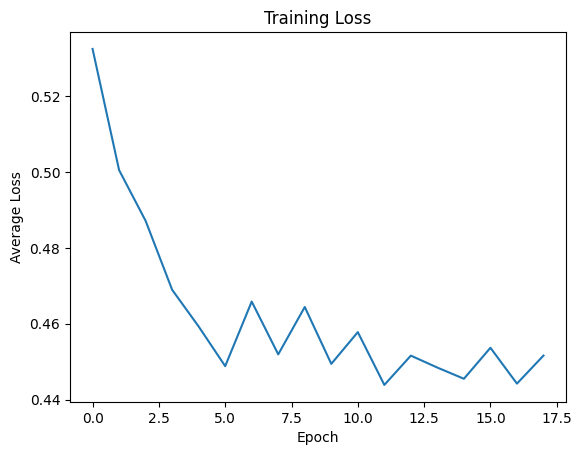

[0.5324059724807739, 0.5004790425300598, 0.48711147904396057, 0.46894699335098267, 0.4592708349227905, 0.4488266408443451, 0.465840607881546, 0.45193901658058167, 0.46441450715065, 0.4494321644306183, 0.4577914774417877, 0.4438841938972473, 0.4516020119190216, 0.4484502673149109, 0.44550591707229614, 0.45366960763931274, 0.4442271888256073, 0.4516150653362274]


In [ ]:
transe = TransE(num_entities=num_entities, num_relations=num_relations, embedding_dim=50, learning_rate=0.01, margin=1.0, norm='l1')
transe.train(train_data, validation_triples=valid_data, num_epochs=18, batch_size=128)

In [ ]:
mean_rank_raw, hits_at_10_raw = transe.raw_test(test_data)
print(f'Raw test results: Mean Rank = {mean_rank_raw}, Hits@10 = {hits_at_10_raw}')

mean_rank_filt, hits_at_10_filt = transe.filtered_test(test_data, train_data+valid_data+test_data)
print(f'Filtered test results: Mean Rank = {mean_rank_filt}, Hits@10 = {hits_at_10_filt}')


Raw test results: Mean Rank = 14115.367363003843, Hits@10 = 1.6928780619931947e-05


KeyboardInterrupt: ignored

Epoch 1/18, Batch 1/3775: average loss = 0.27957281470298767
Epoch 1/18, Batch 501/3775: average loss = 0.3555055856704712
Epoch 1/18, Batch 1001/3775: average loss = 0.34600284695625305
Epoch 1/18, Batch 1501/3775: average loss = 0.4569862484931946
Epoch 1/18, Batch 2001/3775: average loss = 0.37661686539649963
Epoch 1/18, Batch 2501/3775: average loss = 0.4080585241317749
Epoch 1/18, Batch 3001/3775: average loss = 0.3081638216972351
Epoch 1/18, Batch 3501/3775: average loss = 0.216866135597229
Epoch 1/18, Validation Loss = 0.43715834617614746
Epoch 2/18, Batch 1/3775: average loss = 0.24213770031929016
Epoch 2/18, Batch 501/3775: average loss = 0.37797823548316956
Epoch 2/18, Batch 1001/3775: average loss = 0.3566626012325287
Epoch 2/18, Batch 1501/3775: average loss = 0.6650228500366211
Epoch 2/18, Batch 2001/3775: average loss = 0.5717135071754456
Epoch 2/18, Batch 2501/3775: average loss = 0.4530947208404541
Epoch 2/18, Batch 3001/3775: average loss = 0.3174237012863159
Epoch 2/1

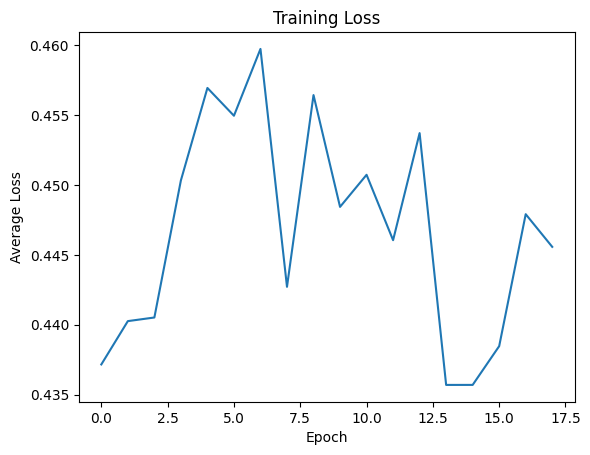

[0.43715834617614746, 0.44025975465774536, 0.44051888585090637, 0.4503336250782013, 0.4569496512413025, 0.4549604058265686, 0.4597436189651489, 0.4427151381969452, 0.45644068717956543, 0.4484364092350006, 0.45073404908180237, 0.44605258107185364, 0.45371881127357483, 0.435692697763443, 0.43569403886795044, 0.43846818804740906, 0.4479137361049652, 0.44557589292526245]


In [ ]:
transe.train(train_data, validation_triples=valid_data, num_epochs=18, batch_size=128)

In [ ]:
mean_rank_raw, hits_at_10_raw = transe.raw_test(test_data)
print(f'Raw test results: Mean Rank = {mean_rank_raw}, Hits@10 = {hits_at_10_raw}')

Raw test results: Mean Rank = 14225.659113609046, Hits@10 = 0.0
